In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mayo-clinic-strip-ai/sample_submission.csv
/kaggle/input/mayo-clinic-strip-ai/train.csv
/kaggle/input/mayo-clinic-strip-ai/test.csv
/kaggle/input/mayo-clinic-strip-ai/other.csv
/kaggle/input/mayo-clinic-strip-ai/other/314263_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/0b33d7_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/54334d_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/84c279_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/cca9eb_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/880188_1.tif
/kaggle/input/mayo-clinic-strip-ai/other/2e3078_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/9daa03_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/065053_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/8acdfa_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/91530f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/a2253f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/f5eb8f_1.tif
/kaggle/input/mayo-clinic-strip-ai/other/ab830f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/d17ad3_2.tif

In [2]:
# Importing Libraries
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from openslide import OpenSlide
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_df = pd.read_csv("../input/mayo-clinic-strip-ai/train.csv")
test_df = pd.read_csv("../input/mayo-clinic-strip-ai/test.csv")
other_df = pd.read_csv("../input/mayo-clinic-strip-ai/other.csv")

## Exploring the Dataset

In [4]:
train_df.head(5)

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [5]:
train_df.shape

(754, 5)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int64 
 2   patient_id  754 non-null    object
 3   image_num   754 non-null    int64 
 4   label       754 non-null    object
dtypes: int64(2), object(3)
memory usage: 29.6+ KB


In [7]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# Avoid memory intensive tasks which could cause the kernel to restart

def reduce_mem_usage(df): 
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df.head(3)

In [8]:
print('Train_df')
print(reduce_mem_usage(train_df))
print('\n')
print('Test_df')
print(reduce_mem_usage(test_df))
print('\n')
print('Other_df')
print(reduce_mem_usage(other_df))
print('\n')

Train_df
   image_id  center_id patient_id  image_num label
0  006388_0         11     006388          0    CE
1  008e5c_0         11     008e5c          0    CE
2  00c058_0         11     00c058          0   LAA


Test_df
   image_id  center_id patient_id  image_num
0  006388_0         11     006388          0
1  008e5c_0         11     008e5c          0
2  00c058_0         11     00c058          0


Other_df
   image_id patient_id  image_num other_specified    label
0  01f2b3_0     01f2b3          0             NaN  Unknown
1  01f2b3_1     01f2b3          1             NaN  Unknown
2  02ebd5_0     02ebd5          0             NaN  Unknown




In [9]:
# Creating Image Path Column
train_df['image_path'] = train_df['image_id'].apply(lambda x: "../input/mayo-clinic-strip-ai/train/" + x + ".tif")
train_df.head(3)

,image_id,center_id,patient_id,image_num,label,image_path
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif


In [10]:
# Look for Label Balance
train_df["label"].value_counts()

CE     547
LAA    207
Name: label, dtype: int64

<AxesSubplot: xlabel='image_num', ylabel='count'>

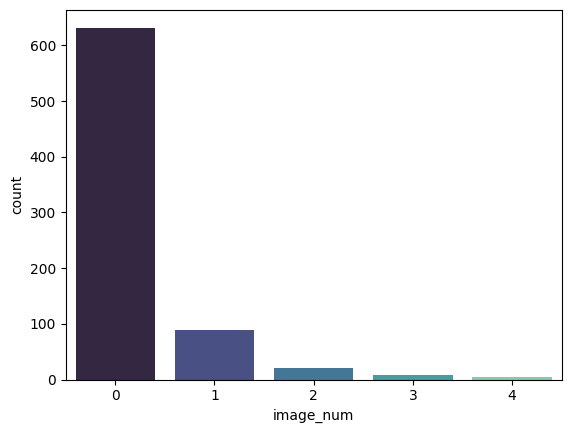

In [11]:
# Counting Number of Images per Patient Distribution
sns.countplot(data=train_df, x='image_num', order=train_df['image_num'].value_counts().index, palette='mako')

This plot indicates that most patients have only one image

<AxesSubplot: xlabel='label', ylabel='count'>

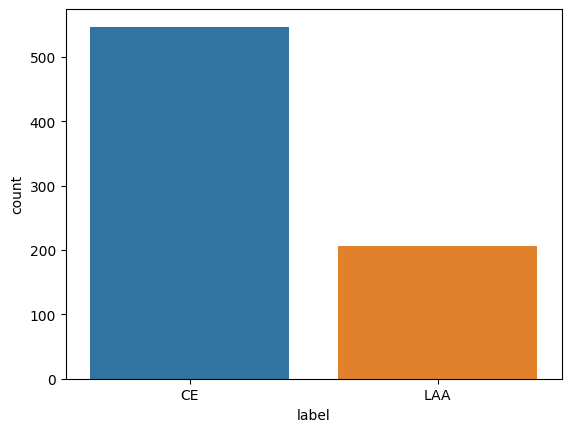

In [12]:
# Count Number of Labels 
sns.countplot(data=train_df, x='label')

### Visualize Sample Image

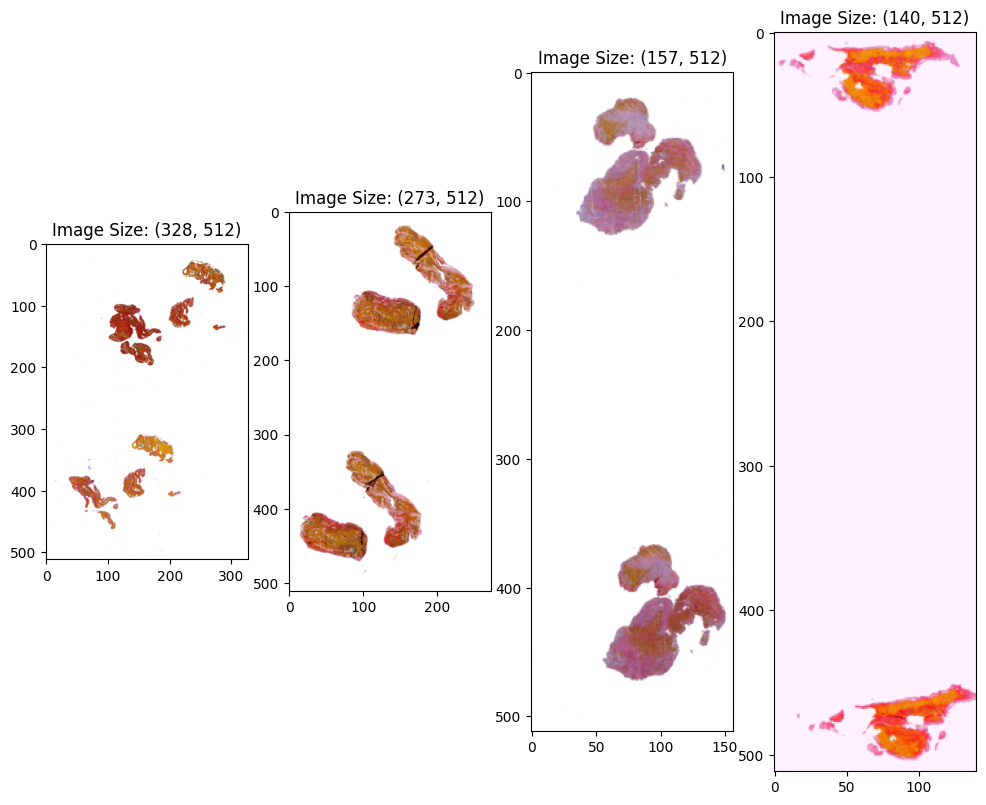

In [13]:
Image.MAX_IMAGE_PIXELS = None
size = (512,512)

fig, axs = plt.subplots(1, 4, figsize = (12, 12))

for i in range(4):
    random_index = np.random.randint(0,len(train_df["image_path"])-1)
    image_path = train_df["image_path"][random_index]
    im = Image.open(image_path)
    im.thumbnail(size)
    axs[i].set_title(f'Image Size: {im.size}')
    axs[i].imshow(im)
    
plt.show()

In [14]:
def visualize_ttf(image_path):
    image = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)
    return image


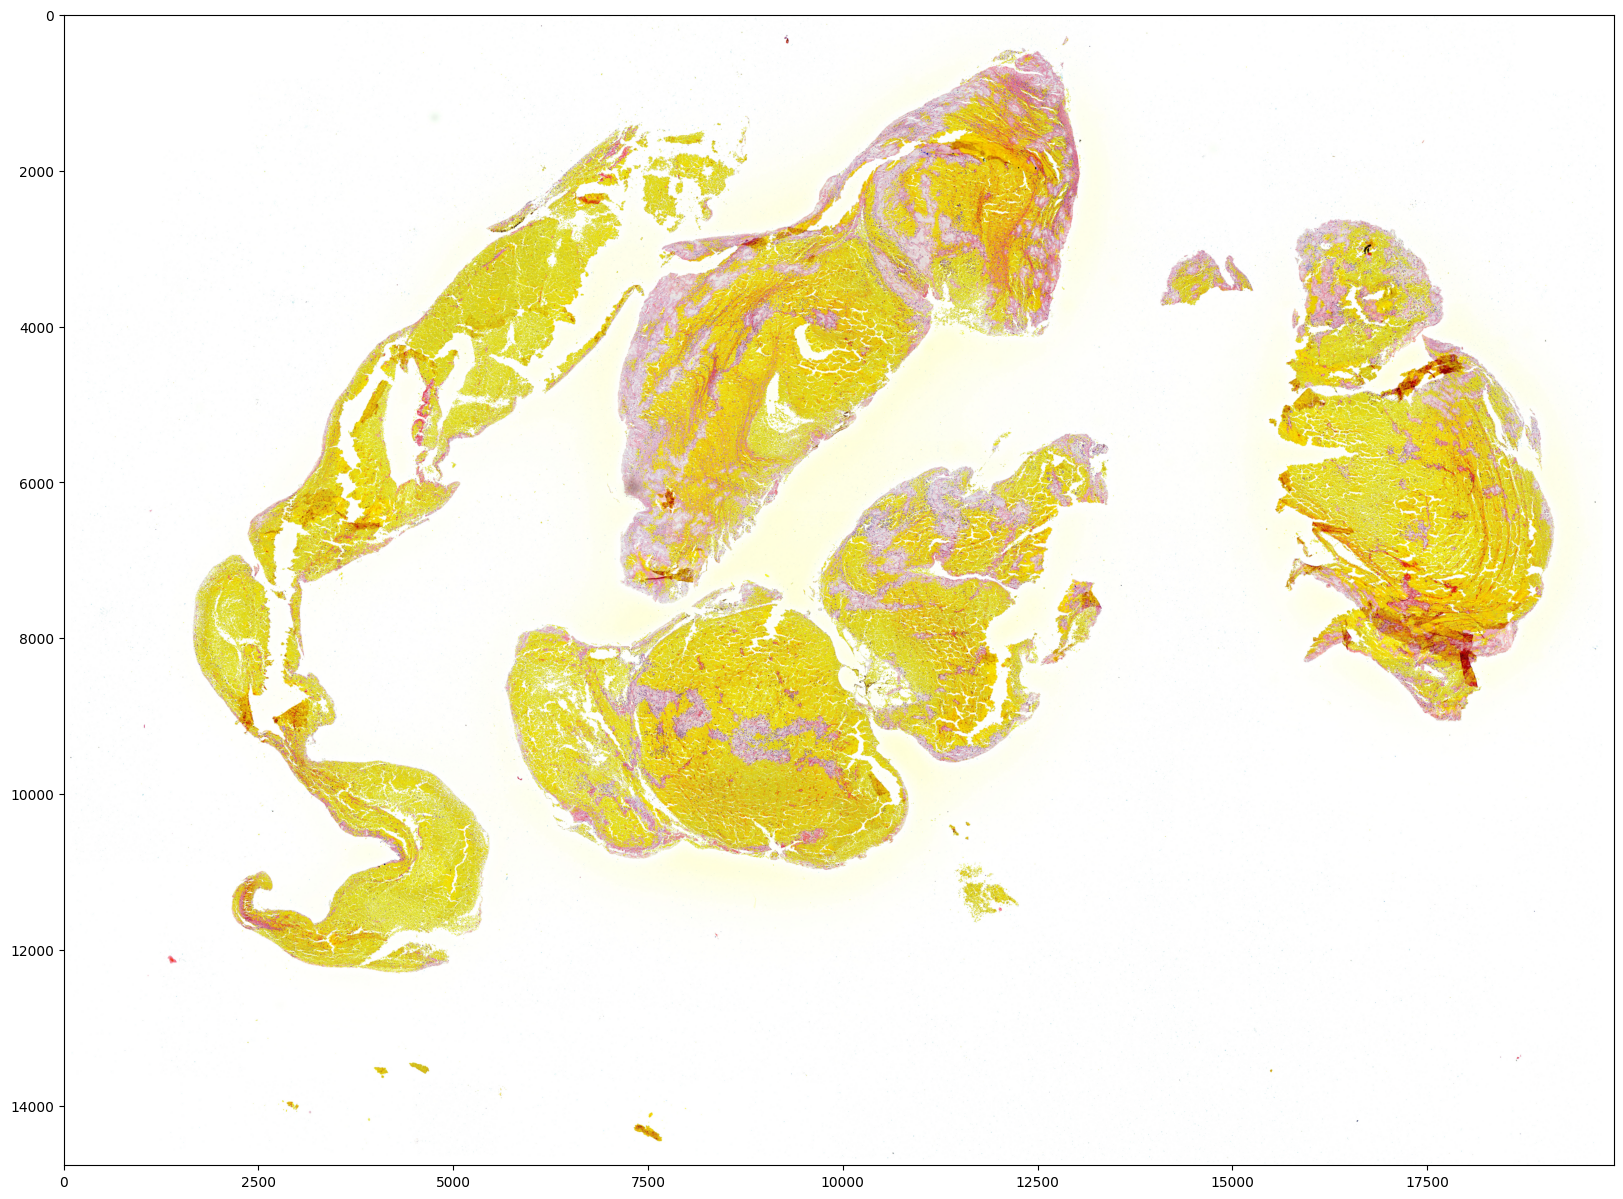

In [15]:
random_image_path = '../input/mayo-clinic-strip-ai/train/31adaa_0.tif'
random_image = visualize_ttf(random_image_path)
figure = plt.figure(figsize=(20,20))
plt.imshow(random_image)

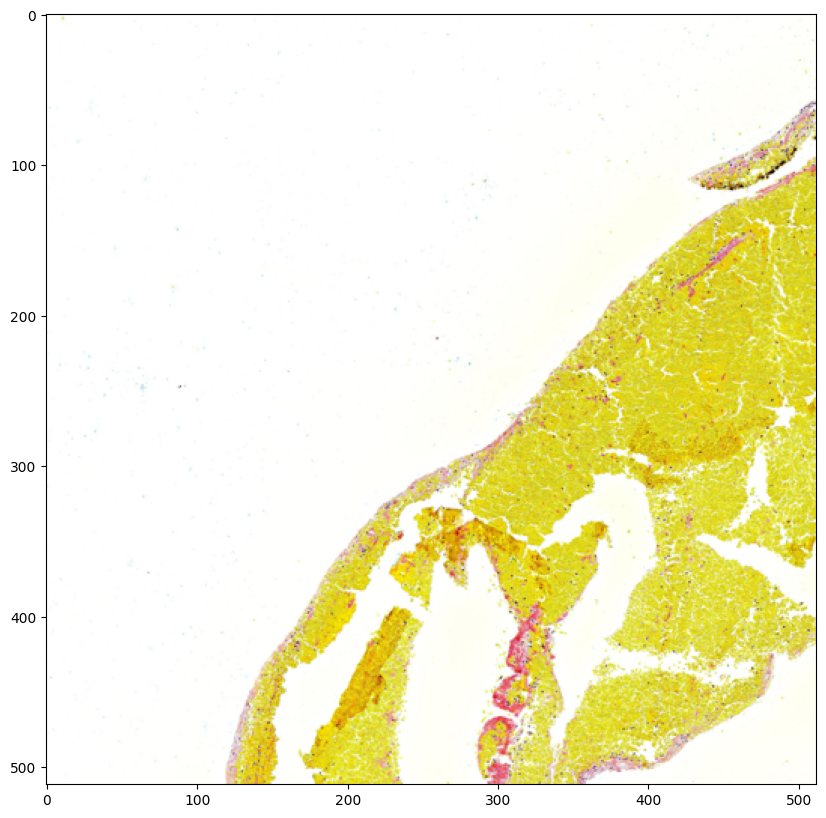

In [16]:
slide = OpenSlide('../input/mayo-clinic-strip-ai/train/31adaa_0.tif')
region = (2500, 2000) # location of the top left pixel
level = 0 # level of the picture (we have only 0)
size = (3500, 3500) # region size in pixels

region = slide.read_region(region, level, size)
image = region.resize((512, 512))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [17]:
# See patients that have multiple images
patients_with_several_images_grouped = train_df[['patient_id', 'image_num']].groupby(by=['patient_id'], as_index=False).count().query('image_num > 1')

In [18]:
patients_with_several_images = train_df[train_df['patient_id'].isin(patients_with_several_images_grouped['patient_id'])][['patient_id', 'label', 'image_id']].groupby(by=['patient_id', 'label'], as_index=False).count()

In [19]:
patients_with_several_images = pd.merge(left=patients_with_several_images, right=patients_with_several_images_grouped, how="inner", on = 'patient_id')

In [20]:
patients_with_several_images

,patient_id,label,image_id,image_num
0,0468a8,CE,2,2
1,049194,CE,2,2
2,09644e,CE,5,5
3,0b7871,CE,2,2
4,0e696a,CE,2,2
...,...,...,...,...
84,fb5f7e,CE,2,2
85,fbdcde,LAA,2,2
86,fdce0f,CE,3,3
87,fdf998,CE,2,2


## Preprocessing the Data

In [21]:
train_df["file_path"] = train_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/train/" + x + ".tif")
test_df["file_path"]  = test_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/test/" + x + ".tif")

In [22]:
train_df["target"] = train_df["label"].apply(lambda x : 1 if x=="CE" else 0)
train_df.head()

,image_id,center_id,patient_id,image_num,label,image_path,file_path,target
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif,../input/mayo-clinic-strip-ai/train/006388_0.tif,1
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,1
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif,../input/mayo-clinic-strip-ai/train/00c058_0.tif,0
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,0
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif,../input/mayo-clinic-strip-ai/train/026c97_0.tif,1


In [23]:
def image_preprocessing(image_path):
    img = OpenSlide(image_path)
    region= (2500,2500)    
    size  = (5000, 5000)
    image = img.read_region(region, 0, size)
    image = image.resize((128, 128))
    image = np.array(image)    
    return image

In [24]:
X_train = []
for file in train_df["file_path"]:
    X_train.append(image_preprocessing(file))

In [25]:
y_train = train_df["target"]

In [26]:
X_train=np.array(X_train)
X_train=X_train/255.0 # normalize
y_train = np.array(y_train)

In [27]:
# Splitting data
x_train,x_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.2, random_state=42)


## Creating the Model

In [28]:
len(tf.config.list_physical_devices("GPU"))

1

In [29]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras import metrics
from sklearn.metrics import f1_score
from sklearn.utils import compute_class_weight

In [30]:
# Create the model architecture
def create_model():
    model = tf.keras.models.Sequential([
        Input(shape = (128,128,4)),
        Conv2D(64, 3, padding = "valid", activation = "relu"),
        MaxPooling2D(),
        Conv2D(64, 3, padding = "valid", strides = 2, activation = "relu"),
        Conv2D(64, 3, padding = "valid", strides = 2, activation = "relu"),
        Conv2D(64, 3, padding = "valid", strides = 2, activation = "relu"),
        Conv2D(128, 3, padding = "valid", strides = 2, activation = "relu"),
        Conv2D(128, 3, padding = "valid", strides = 2, activation = "relu"),
#         Dropout(0.15),
        Flatten(),
        Dense(256, activation = "relu"),
#         Dropout(0.15),
        Dense(100, activation = "relu"),
        Dense(50, activation = "relu"),
        Dense(1, activation = "sigmoid")
    ])
    
    return model

In [31]:
# Initialize model
model = create_model()

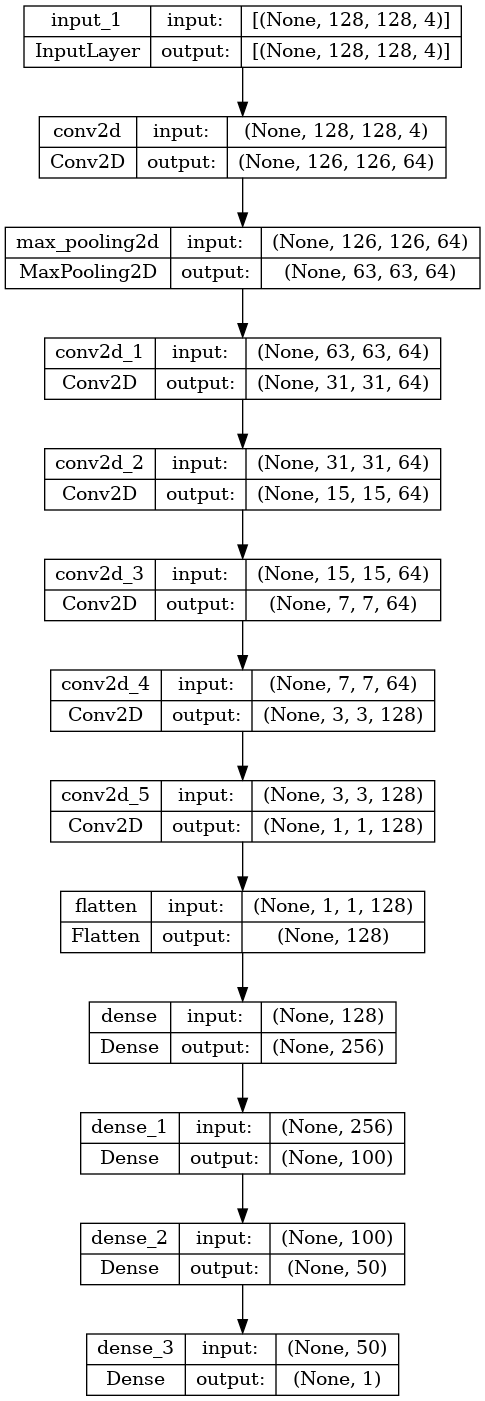

In [32]:
dot_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [33]:
# Compile the model
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=[metrics.binary_accuracy],
    optimizer = tf.keras.optimizers.Adam(1e-3))

In [34]:
# Since labels are unbalanced we will use class weights
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

In [35]:
class_weights

{0: 1.9082278481012658, 1: 0.6775280898876405}

In [36]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_CNN.h5',
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True, verbose=1)

In [37]:
type(class_weights)

dict

In [38]:
y_val

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1])

In [39]:
model.fit(x_train, y_train, epochs = 10, batch_size=20, validation_data = (x_val,y_val), class_weight= class_weights, callbacks = callback)

Epoch 1/10
31/31 [==============================] - ETA: 0s - loss: 0.6945 - binary_accuracy: 0.6551
Epoch 1: val_binary_accuracy improved from -inf to 0.41722, saving model to best_CNN.h5
31/31 [==============================] - 11s 35ms/step - loss: 0.6945 - binary_accuracy: 0.6551 - val_loss: 0.6932 - val_binary_accuracy: 0.4172
Epoch 2/10
29/31 [===========================>..] - ETA: 0s - loss: 0.6888 - binary_accuracy: 0.7069
Epoch 2: val_binary_accuracy improved from 0.41722 to 0.67550, saving model to best_CNN.h5
31/31 [==============================] - 1s 20ms/step - loss: 0.6933 - binary_accuracy: 0.7032 - val_loss: 0.6905 - val_binary_accuracy: 0.6755
Epoch 3/10
31/31 [==============================] - ETA: 0s - loss: 0.6937 - binary_accuracy: 0.7380
Epoch 3: val_binary_accuracy did not improve from 0.67550
31/31 [==============================] - 0s 14ms/step - loss: 0.6937 - binary_accuracy: 0.7380 - val_loss: 0.6915 - val_binary_accuracy: 0.6755
Epoch 4/10
31/31 [=========

In [41]:
best_cnn = tf.keras.models.load_model('/kaggle/working/best_CNN.h5')
best_cnn.evaluate(x_val,y_val)

5/5 [==============================] - 0s 23ms/step - loss: 0.6877 - binary_accuracy: 0.6821


[0.6877270936965942, 0.6821191906929016]

In [42]:
from mlxtend.plotting import plot_confusion_matrix

5/5 [==============================] - 0s 6ms/step


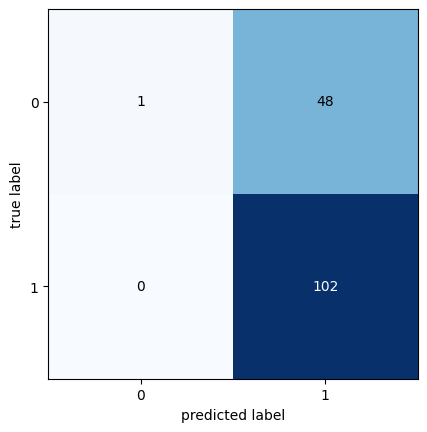

In [48]:
# Confusion matrix
val_preds = best_cnn.predict(x_val)
val_preds = (val_preds >= 0.5).astype(np.int32)
conf_matrix = tf.math.confusion_matrix(labels = y_val, predictions = val_preds, num_classes = 2)
fig, ax = plot_confusion_matrix(conf_mat=np.array(conf_matrix))
plt.show()

Note: 1 - CE, 0 - LAA. The model is currently only predicting CE for almost all of the samples. This may be due to the imbalance of the targets. 

## Predicting on Test Data

In [49]:
x_test = []
for file in test_df["file_path"]:
    img = image_preprocessing(file)
    x_test.append(img)
x_test = np.array(x_test)

In [50]:
test_pred = best_cnn.predict(x_test)
test_pred

1/1 [==============================] - 0s 137ms/step


array([[0.5815565 ],
       [0.04097936],
       [0.63411963],
       [0.5692045 ]], dtype=float32)

In [54]:
sub = pd.DataFrame(test_df["patient_id"].copy())
sub["CE"] = test_pred
sub["LAA"] = 1- sub["CE"]

sub = sub.groupby("patient_id").mean()
sub = sub[["CE", "LAA"]].round(4).reset_index()
sub

,patient_id,CE,LAA
0,006388,0.5816,0.4184
1,008e5c,0.0410,0.9590
2,00c058,0.6341,0.3659
3,01adc5,0.5692,0.4308


In [55]:
sub.to_csv("submission.csv", index = False)